# 4. DCGAN Model

| Task                   | Sub-task                                | Comments                                  |
|------------------------|-----------------------------------------|-------------------------------------------|
| Data Preprocessing     | Scaling and Resizing                    | Done                                      |
|                        | Image Augmentation                      | Done                                      |
| Model Trained          | Training Time?                         |     8 epochs in 6108 seconds using GPU P100                                 |
|                        | Building Generator and Discriminator with Losses                     | Done                                      |
|                        | Combining Generator and Discriminator                      | Done                                      |
| Images Generation       | 4 Images Generation           | Done                                      |


In [1]:
# basic libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

In [2]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal

2024-04-08 16:32:55.076830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 16:32:55.076926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 16:32:55.216239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# other imports
import PIL

In [13]:
# constants
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 128
STEPS_PER_EPOCH = 500
EPOCHS = 8
NOISE_DIM = 100

## 4.1. Data Preprocessing

In [5]:
# check for all images to be considered in dataset
image_paths = []
for root, dirs, files in os.walk("/kaggle/input/face-expressions/dataset"):
    for file in files:
        image_paths.append(os.path.join(root, file))

In [6]:
# function for image preprocessing
def preprocess_image(path,image_size=IMAGE_SIZE):
    img = np.asarray(PIL.Image.open(path).resize(IMAGE_SIZE))
    img = ((img - 127.5) / 127.5).astype("float32")
    return img

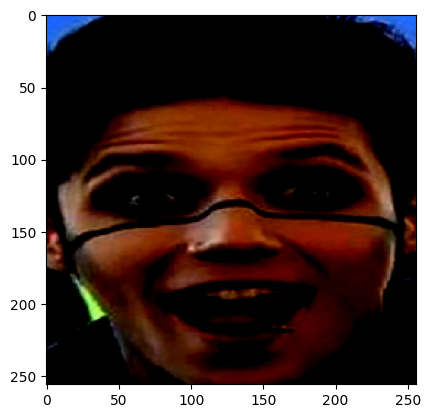

In [7]:
# check test image
test_img = preprocess_image(image_paths[0])
plt.imshow(test_img)
plt.show()

In [8]:
# datagen creation
def data_generator(batch_size):
    while True:
        paths = random.choices(image_paths,k=batch_size)
        batch = []
        for p in paths:
            batch.append(preprocess_image(p))
        yield np.asarray(batch)

data_gen = data_generator(BATCH_SIZE)

## 4.2. Model Building

In [9]:
# function to build generator
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16,16,256)))
    assert model.output_shape == (None,16,16,256)
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=RandomNormal(mean=0.0,stddev=0.2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None,32,32,128)
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=RandomNormal(mean=0.0,stddev=0.2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None,64,64,128)
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=RandomNormal(mean=0.0,stddev=0.2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None,128,128,64)
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=RandomNormal(mean=0.0,stddev=0.2), activation="tanh"))
    assert model.output_shape == (None,256,256,3)
    return model

In [10]:
# function to build discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(256,256,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(265,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [11]:
# initialize cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
# function for generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [14]:
# functions for discriminator loss
def discriminator_loss(real_images,fake_images):
    real_loss = cross_entropy(tf.ones_like(real_images),real_images)
    fake_loss = cross_entropy(tf.zeros_like(fake_images),fake_images)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
# initialize generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [16]:
# initialize optimizers
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [17]:
# tensorflow function for training steps
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [18]:
# function to train with epochs
def train(epochs):
    for epoch in range(epochs):
        start = time.time()
        for step in range(STEPS_PER_EPOCH):
            train_step(next(data_gen))
            sys.stdout.write(f"\rSTEP: {step}/{STEPS_PER_EPOCH}")
            sys.stdout.flush()
        finish_time = round(time.time() - start,2)
        print(f"Epoch {epoch}/{epochs} Process Time : {finish_time}")
        print("-"*15)

In [19]:
# train with 8 epochs
train(EPOCHS)

2024-04-08 16:35:16.469002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


STEP: 499/500Epoch 0/8 Process Time : 959.43
---------------
STEP: 499/500Epoch 1/8 Process Time : 775.73
---------------
STEP: 499/500Epoch 2/8 Process Time : 731.97
---------------
STEP: 499/500Epoch 3/8 Process Time : 725.65
---------------
STEP: 499/500Epoch 4/8 Process Time : 733.34
---------------
STEP: 499/500Epoch 5/8 Process Time : 729.24
---------------
STEP: 499/500Epoch 6/8 Process Time : 729.25
---------------
STEP: 499/500Epoch 7/8 Process Time : 727.86
---------------


## 4.3. Images Generation

In [23]:
# code for image generation
noise = tf.random.normal([4,100])
generated_images = np.asarray(generator(noise,training=False))

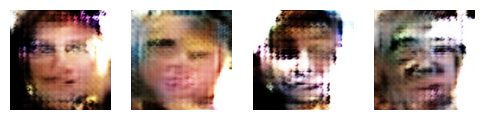

In [24]:
# checking generated images
fig = plt.figure(figsize=(6,6))
for i in range(4):
    plt.subplot(4,4,i+1)
    plt.imshow((generated_images[i,:,:,:]*127.5+127.5).astype("int"))
    plt.axis("off")  
plt.show()

## 4.4. Model Saving

In [25]:
# save model
generator.save('dcgan_generator.h5')

## References

* “Introduction to Face Generation Using DCGAN.” Kaggle.com, www.kaggle.com/code/shyambhu/introduction-to-face-generation-using-dcgan.